# FEATURE EXTRACTION

In [1]:
# you start empty df
# loop over mt files
# create subdf that has only movement for the particular tier
# and then you calculate for this file whatever you want
# and append it to the empty df with the trialID 
import os
import glob
import pandas as pd
import numpy as np
import math
import pyentrp


#import antropy as ant
import pyentrp

from pyentrp import entropy as ent

import scipy
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import math

import xml.etree.ElementTree as ET


curfolder = os.getcwd()
print(curfolder)

mtfolder = curfolder + '/TS_movement/'
print(mtfolder)

mtfiles = glob.glob(mtfolder + '*.csv')

demographics = curfolder + "/LNDW.csv"



# create an empty dataframe where I will store all of the features.



/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/


In [20]:
# gesture space calculator: 

def gesturespace(sample, joint, side, movement_type): 
    #fileID = sample["fileID"]
    #fileID = fileID.replace('_comr.mp4', '')
    #get the subdf for where there is only arm movement. 
    total_movement = int(0)
    movement_sample = sample[sample[movement_type] == 'movement']
    if movement_sample.empty:
        return 0
    else:
        X_std = np.std(movement_sample["X_" + side + joint])
        Y_std = np.std(movement_sample["Y_" + side + joint])
        Z_std = np.std(movement_sample["Z_" + side + joint])
        total_movement = X_std + Y_std + Z_std
        return total_movement
    
def gesturespace2D(sample, joint, side, movement_type): 
    #fileID = sample["fileID"]
    #fileID = fileID.replace('_comr.mp4', '')
    #get the subdf for where there is only arm movement. 
    total_movement = int(0)
    movement_sample = sample[sample[movement_type] == 'movement']
    if movement_sample.empty:
        return 0
    else:
        X_std = np.std(movement_sample["X_" + side + joint])
        Y_std = np.std(movement_sample["Y_" + side + joint])
        total_movement = X_std + Y_std
        return total_movement

# entropy calculator
def entrophyts(sample, joint, side, movement_type):
    movement_sample = sample[sample[movement_type] == "movement"]
    if movement_sample.empty:
        return 0
    else:
        speed_ts = (movement_sample[side + joint + "_speed"]).values
        sample_entropy = ent.sample_entropy(speed_ts, 1)
        return sample_entropy
    
def entrophyts2D(sample, joint, side, movement_type):
    movement_sample = sample[sample[movement_type] == "movement"]
    if movement_sample.empty:
        return 0
    else:
        speed_ts = (movement_sample[side + joint + "_speed2D"]).values

        sample_entropy = ent.sample_entropy(speed_ts, 1)
        perm_entropy = ent.permutation_entropy(speed_ts)
        return perm_entropy

def temporal_variability_function(sample, joint, side, movement_type):
    movement_sample = sample[sample[movement_type] == "movement"]
    if movement_sample.empty:
        return 0
    else:
        speed_ts = (movement_sample[side + joint + "_speed"]).to_numpy()
        avg_height = np.mean(speed_ts)
        peaks, _ = scipy.signal.find_peaks(speed_ts, avg_height)
        if len(peaks) > 2:
            diff_in_peaks = np.empty(len(peaks)-1)
            for i in range(len(peaks)-1): 
                current_peak = sample.loc[peaks[i], "time" ]
                next_peak = sample.loc[peaks[i+1], "time" ]
                time_between_peaks = next_peak - current_peak
                diff_in_peaks[i] = time_between_peaks
            temporal_variability= np.std(diff_in_peaks)
            return temporal_variability
        else:
            return 0

def temporal_variability_function2D(sample, joint, side, movement_type):
    movement_sample = sample[sample[movement_type] == "movement"]
    if movement_sample.empty:
        return 0
    else:
        speed_ts = (movement_sample[side + joint + "_speed2D"]).to_numpy()
        avg_height = np.mean(speed_ts)
        peaks, _ = scipy.signal.find_peaks(speed_ts, avg_height)
        if len(peaks) > 2:
            diff_in_peaks = np.empty(len(peaks)-1)
            for i in range(len(peaks)-1): 
                current_peak = sample.loc[peaks[i], "time" ]
                next_peak = sample.loc[peaks[i+1], "time" ]
                time_between_peaks = next_peak - current_peak
                diff_in_peaks[i] = time_between_peaks
            temporal_variability= np.std(diff_in_peaks)
            return temporal_variability
        else:
            return 0
    


In [21]:
# creates the dataframe of features
featuredf = pd.DataFrame()

# gets the survey information
demographics_read = pd.read_csv(demographics)

# adds survey columns to the features csv file
columns_to_add = demographics_read.columns
for col in columns_to_add:
    featuredf[col] = pd.NA


# Big For Loop For Feature Extraction

In [22]:
# big loop to loop through all of the files and extract features

count = 0
for file in mtfiles:
    print(file)
    sample = pd.read_csv(file)

    # get the fileID 
    featuredf.loc[count, "fileID"] = (sample["fileID"])[0]

    # get the chainID and the participantID
    featuredf.loc[count, "chainID"] = sample["participantID"][0]
    chainID = featuredf["chainID"][count]
    split_string = chainID.split('ch')[1]
    split_string = split_string.split('g')
    chain_num = split_string[0]
    gen_num = split_string[1]
    featuredf.loc[count, "generation_number"] = int(gen_num)
    participantID = int(chain_num) * int(gen_num)
    featuredf.loc[count, "participantID"] = participantID

    # get the demographic information from the survey and puts it in correct row in featuredf 
    matching_rows = demographics_read[demographics_read["Q1"] == str(int(participantID))]
    if len(matching_rows) >0:
        demographic_row = matching_rows.iloc[0]
        matching_row = demographics_read[demographics_read["Q1"] == str(int(participantID))]
        featuredf.loc[count, columns_to_add] = matching_row.iloc[0].values
    else:
        print("no matching demographics row")

    #Get the gesture space measures (should I move this into a function itself?)
    '''
    #left arm
    featuredf.loc[count, "left_index_space"] = gesturespace(sample, "INDEX", "LEFT_", "arms")
    featuredf.loc[count, "left_wrist_space"] = gesturespace(sample, "WRIST", "LEFT_", "arms")
    featuredf.loc[count, "left_elbow_space"] = gesturespace(sample, "ELBOW", "LEFT_", "arms")
    featuredf.loc[count, "total_left_arm_space"] = featuredf.loc[count, "left_index_space"] + featuredf.loc[count, "left_wrist_space"] + featuredf.loc[count, "left_elbow_space"]

    # right arm
    featuredf.loc[count, "right_index_space"] = gesturespace(sample, "INDEX", "RIGHT_", "arms")
    featuredf.loc[count, "right_wrist_space"] = gesturespace(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "right_elbow_space"] = gesturespace(sample, "ELBOW", "RIGHT_", "arms")
    featuredf.loc[count, "total_right_arm_space"] = featuredf.loc[count, "right_index_space"] + featuredf.loc[count, "right_wrist_space"] + featuredf.loc[count, "right_elbow_space"]

    # left leg
    featuredf.loc[count, "left_ankle_space"] = gesturespace(sample, "ANKLE", "LEFT_", "lower_body")
    featuredf.loc[count, "left_knee_space"] = gesturespace(sample, "KNEE", "LEFT_", "lower_body")
    featuredf.loc[count, "left_hip_space"] = gesturespace(sample, "HIP", "LEFT_", "lower_body")
    featuredf.loc[count, "total_left_leg_space"] = featuredf.loc[count, "left_ankle_space"] + featuredf.loc[count, "left_knee_space"] + featuredf.loc[count, "left_hip_space"]

    # right leg
    featuredf.loc[count, "right_ankle_space"] = gesturespace(sample, "ANKLE", "RIGHT_", "lower_body")
    featuredf.loc[count, "right_knee_space"] = gesturespace(sample, "KNEE", "RIGHT_", "lower_body")
    featuredf.loc[count, "right_hip_space"] = gesturespace(sample, "HIP", "RIGHT_", "lower_body")
    featuredf.loc[count, "total_right_leg_space"] = featuredf.loc[count, "right_ankle_space"] + featuredf.loc[count, "right_knee_space"] + featuredf.loc[count, "right_hip_space"]

    # head (nose)
    featuredf.loc[count, "nose_space"] = gesturespace(sample, "NOSE", "", "head_mov")
    featuredf.loc[count, "total_head_space"] = featuredf.loc[count, "nose_space"]

    # total gesture space
    featuredf.loc[count, "total_gesture_space"] = featuredf.loc[count, "total_left_arm_space"] + featuredf.loc[count, "total_right_arm_space"] + featuredf.loc[count, "total_left_leg_space"] + featuredf.loc[count, "total_right_leg_space"] + featuredf.loc[count, 'total_head_space']

    # get the entropy for wrist, knee, and ankle. 
    #wrist entropy
    featuredf.loc[count, "right_wrist_entropy"] = entrophyts(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "left_wrist_entropy"] = entrophyts(sample, "WRIST", "LEFT_", "arms")

    #knees enropy
    featuredf.loc[count, "right_knee_entropy"] = entrophyts(sample, "KNEE", "RIGHT_", "lower_body")
    featuredf.loc[count, "left_knee_entropy"] = entrophyts(sample, "KNEE", "LEFT_", "lower_body")

    #ankle enropy
    featuredf.loc[count, "right_ankle_entropy"] = entrophyts(sample, "ANKLE", "RIGHT_", "lower_body")
    featuredf.loc[count, "left_ankle_entropy"] = entrophyts(sample, "ANKLE", "LEFT_", "lower_body")

    #total_entropy
    featuredf.loc[count, "total_body_entropy"] = featuredf.loc[count, "left_ankle_entropy"]+ featuredf.loc[count, "right_ankle_entropy"] + featuredf.loc[count, "left_knee_entropy"] +featuredf.loc[count, "right_knee_entropy"] + featuredf.loc[count, "left_wrist_entropy"] + featuredf.loc[count, "right_wrist_entropy"]

    # temporal variability
    #wrist
    featuredf.loc[count, "right_wrist_variability"] = temporal_variability_function(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "left_wrist_variability"] = temporal_variability_function(sample, "WRIST", "LEFT_", "arms")

    #total variability
    featuredf.loc[count, 'total_body_variability'] = featuredf.loc[count, "right_wrist_variability"] + featuredf.loc[count, "left_wrist_variability"]

    # NOW HERE I COLLECT ALL OF THE 2D FEATURES: 
    '''
        #left arm
    featuredf.loc[count, "left_index_space2D"] = gesturespace2D(sample, "INDEX", "LEFT_", "arms")
    featuredf.loc[count, "left_wrist_space2D"] = gesturespace2D(sample, "WRIST", "LEFT_", "arms")
    featuredf.loc[count, "left_elbow_space2D"] = gesturespace2D(sample, "ELBOW", "LEFT_", "arms")
    featuredf.loc[count, "total_left_arm_space2D"] = featuredf.loc[count, "left_index_space2D"] + featuredf.loc[count, "left_wrist_space2D"] + featuredf.loc[count, "left_elbow_space2D"]

    # right arm
    featuredf.loc[count, "right_index_space2D"] = gesturespace2D(sample, "INDEX", "RIGHT_", "arms")
    featuredf.loc[count, "right_wrist_space2D"] = gesturespace2D(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "right_elbow_space2D"] = gesturespace2D(sample, "ELBOW", "RIGHT_", "arms")
    featuredf.loc[count, "total_right_arm_space2D"] = featuredf.loc[count, "right_index_space2D"] + featuredf.loc[count, "right_wrist_space2D"] + featuredf.loc[count, "right_elbow_space2D"]

    # left leg
    featuredf.loc[count, "left_ankle_space2D"] = gesturespace2D(sample, "ANKLE", "LEFT_", "lower_body")
    featuredf.loc[count, "left_knee_space2D"] = gesturespace2D(sample, "KNEE", "LEFT_", "lower_body")
    featuredf.loc[count, "left_hip_space2D"] = gesturespace2D(sample, "HIP", "LEFT_", "lower_body")
    featuredf.loc[count, "total_left_leg_space2D"] = featuredf.loc[count, "left_ankle_space2D"] + featuredf.loc[count, "left_knee_space2D"] + featuredf.loc[count, "left_hip_space2D"]

    # right leg
    featuredf.loc[count, "right_ankle_space2D"] = gesturespace2D(sample, "ANKLE", "RIGHT_", "lower_body")
    featuredf.loc[count, "right_knee_space2D"] = gesturespace2D(sample, "KNEE", "RIGHT_", "lower_body")
    featuredf.loc[count, "right_hip_space2D"] = gesturespace2D(sample, "HIP", "RIGHT_", "lower_body")
    featuredf.loc[count, "total_right_leg_space2D"] = featuredf.loc[count, "right_ankle_space2D"] + featuredf.loc[count, "right_knee_space2D"] + featuredf.loc[count, "right_hip_space2D"]

    # head (nose)
    featuredf.loc[count, "nose_space2D"] = gesturespace2D(sample, "NOSE", "", "head_mov")
    featuredf.loc[count, "total_head_space2D"] = featuredf.loc[count, "nose_space2D"]

    # total gesture space
    featuredf.loc[count, "total_gesture_space2D"] = featuredf.loc[count, "total_left_arm_space2D"] + featuredf.loc[count, "total_right_arm_space2D"] + featuredf.loc[count, "total_left_leg_space2D"] + featuredf.loc[count, "total_right_leg_space2D"] + featuredf.loc[count, 'total_head_space2D']

    # get the entropy for wrist, knee, and ankle. 
    #wrist entropy
    featuredf.loc[count, "right_wrist_entropy2D"] = entrophyts2D(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "left_wrist_entropy2D"] = entrophyts2D(sample, "WRIST", "LEFT_", "arms")

    #knees enropy
    featuredf.loc[count, "right_knee_entropy2D"] = entrophyts2D(sample, "KNEE", "RIGHT_", "lower_body")
    featuredf.loc[count, "left_knee_entropy2D"] = entrophyts2D(sample, "KNEE", "LEFT_", "lower_body")

    #ankle enropy
    featuredf.loc[count, "right_ankle_entropy2D"] = entrophyts2D(sample, "ANKLE", "RIGHT_", "lower_body")
    featuredf.loc[count, "left_ankle_entropy2D"] = entrophyts2D(sample, "ANKLE", "LEFT_", "lower_body")

    #total_entropy
    featuredf.loc[count, "total_body_entropy2D"] = featuredf.loc[count, "left_ankle_entropy2D"]+ featuredf.loc[count, "right_ankle_entropy2D"] + featuredf.loc[count, "left_knee_entropy2D"] +featuredf.loc[count, "right_knee_entropy2D"] + featuredf.loc[count, "left_wrist_entropy2D"] + featuredf.loc[count, "right_wrist_entropy2D"]

    # temporal variability
    #wrist
    featuredf.loc[count, "right_wrist_variability2D"] = temporal_variability_function2D(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "left_wrist_variability2D"] = temporal_variability_function2D(sample, "WRIST", "LEFT_", "arms")

    #total variability
    featuredf.loc[count, 'total_body_variability2D'] = featuredf.loc[count, "right_wrist_variability2D"] + featuredf.loc[count, "left_wrist_variability2D"]
    count = count +1



/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/rennen_g_ch3_g12_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/Donner_g_ch2_g3_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/Donner_g_ch1_g16_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch2_g10_compr.eaf.csv
no matching demographics row
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch2_g17_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch2_g6_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/Donner_g_ch1_g5_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/rennen_g_ch2_g6_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch2_g14_compr.eaf.csv
/Users/gillianrosen

/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWa

/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch1_g5_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/rennen_g_ch3_g17_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/Donner_g_ch2_g6_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch2_g15_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/rennen_g_ch1_g5_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/rennen_g_ch2_g7_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch2_g7_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch2_g16_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/Donner_g_ch1_g4_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_Ite

In [35]:
featuredf

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,right_wrist_entropy2D,left_wrist_entropy2D,right_knee_entropy2D,left_knee_entropy2D,right_ankle_entropy2D,left_ankle_entropy2D,total_body_entropy2D,right_wrist_variability2D,left_wrist_variability2D,total_body_variability2D
0,2024-06-22 20:56:58,2024-06-22 20:59:26,IP Address,80.187.86.160,100,148,True,2024-06-22 20:59:27,R_2PNn6u3joW9B5IJ,NaN,...,1.67584,2.58223,0.0,0.0,0.0,0.0,4.25807,0.0,0.0,0.0


# code to plot the features for each chain

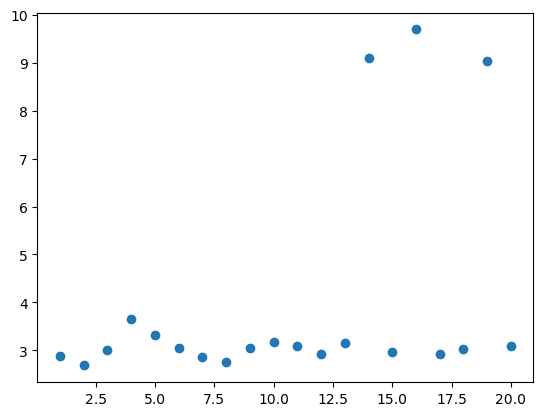

In [25]:
samplechainD = featuredf[featuredf['fileID'].str.contains("leise_g_ch3")]

#plt.plot(samplechainD['generation_number'], samplechainD['total_gesture_space'], marker='o', linestyle='')
#plt.plot(samplechainD['generation_number'], samplechainD['total_gesture_space2D'], marker='o', linestyle='')
#plt.plot(samplechainD['generation_number'], samplechainD['right_wrist_space'], marker='o', linestyle='')
#plt.plot(samplechainD['generation_number'], samplechainD['right_wrist_space2D'], marker='o', linestyle='')

#plt.plot(samplechainD['generation_number'], samplechainD['total_body_entropy'], marker='o', linestyle='')
plt.plot(samplechainD['generation_number'], samplechainD['total_body_entropy2D'], marker='o', linestyle='')

#plt.plot(samplechainD['generation_number'], samplechainD['total_body_variability'], marker='o', linestyle='')
#plt.plot(samplechainD['generation_number'], samplechainD['total_body_variability2D'], marker='o', linestyle='')
#plt.plot(samplechainD['generation_number'], samplechainD['total_body_entropy2D'], marker='o', linestyle='')


In [44]:
samplechainD

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,right_wrist_entropy2D,left_wrist_entropy2D,right_knee_entropy2D,left_knee_entropy2D,right_ankle_entropy2D,left_ankle_entropy2D,total_body_entropy2D,right_wrist_variability2D,left_wrist_variability2D,total_body_variability2D
7,2024-06-22 18:03:09,2024-06-22 18:05:02,IP Address,80.187.86.216,100,113,True,2024-06-22 18:05:03,R_2geuqXPNJd7koGl,NaN,...,2.811047,2.739922,2.656909,2.720871,2.763551,2.742611,16.516995,119.931244,70.873205,190.804449
14,2024-06-22 17:32:43,2024-06-22 17:33:55,IP Address,176.0.200.68,100,72,True,2024-06-22 17:33:55,R_2ziH7Mzu9vZTMte,NaN,...,2.858737,2.802949,2.883880,2.622031,2.754709,2.659613,16.755805,133.361976,152.559187,285.921163
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.474358,2.548762,2.639177,2.237299,2.905679,2.518983,15.392359,103.577966,134.090443,237.668409
31,2024-06-22 20:40:38,2024-06-22 20:41:50,IP Address,195.37.172.125,100,71,True,2024-06-22 20:41:50,R_2ITaokxupfNc5aE,NaN,...,2.563801,2.676716,2.673455,2.349928,2.729637,2.220477,15.293803,353.645450,195.248893,548.894343
38,2024-06-22 19:40:05,2024-06-22 19:44:13,IP Address,195.37.172.125,100,248,True,2024-06-22 19:44:14,R_2QJURmQ1dda9o9S,NaN,...,2.913865,2.686610,2.756595,2.413042,2.822164,2.739588,16.405324,108.473467,121.874505,230.347972
47,2024-06-22 20:44:36,2024-06-22 20:46:02,IP Address,80.187.85.2,100,85,True,2024-06-22 20:46:02,R_8gZtXK5xIfoQH67,NaN,...,2.737254,2.650783,2.473802,2.721464,2.102488,2.683643,15.442592,118.928512,115.220064,234.148576
61,2024-06-22 18:02:30,2024-06-22 18:03:36,IP Address,176.1.231.251,100,66,True,2024-06-22 18:03:36,R_8MKVK9awzFX6heW,NaN,...,2.751496,2.635583,2.639884,2.724600,2.778204,2.668507,16.143253,101.002973,133.329264,234.332237
78,2024-06-22 17:14:18,2024-06-22 17:16:26,IP Address,109.40.242.194,100,127,True,2024-06-22 17:16:26,R_2KIpvLjRioa2KCq,NaN,...,2.738394,2.957055,2.630306,2.864909,2.693951,2.866605,16.680757,128.166344,205.487226,333.653570
111,2024-06-22 20:56:58,2024-06-22 20:59:26,IP Address,80.187.86.160,100,148,True,2024-06-22 20:59:27,R_2PNn6u3joW9B5IJ,NaN,...,2.880133,2.733916,2.873359,2.809956,2.197034,2.300083,16.214573,83.638763,73.804297,157.443060
141,2024-06-22 18:30:47,2024-06-22 18:32:31,IP Address,80.187.84.147,100,104,True,2024-06-22 18:32:32,R_2CBcu7cAm27UMef,NaN,...,2.542564,2.679110,2.589399,2.796893,2.685341,2.767817,16.143620,149.261219,296.168954,445.430173


# Saves the df to the feature extraction file

In [46]:
globals()["feature_extraction"] = samplechainD
globals()["feature_extraction"].to_csv(os.path.join(curfolder, f'{"feature_extraction_with2d"}.csv'), index=False)

# feature extraction for a single file

In [7]:
file = "/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch2_g10_compr.eaf.csv"
sample = pd.read_csv(file)
variability = temporal_variability_function(sample, "WRIST", "RIGHT_", "arms")
print(variability)

0


In [50]:
sample

,time,X_NOSE,Y_NOSE,Z_NOSE,X_LEFT_EYE_INNER,Y_LEFT_EYE_INNER,Z_LEFT_EYE_INNER,X_LEFT_EYE,Y_LEFT_EYE,Z_LEFT_EYE,...,RIGHT_EAR_jerk,LEFT_PINKY_jerk,LEFT_HIP_jerk,NOSE_jerk,LEFT_ELBOW_jerk,LEFT_THUMB_jerk,arms,upper_body,lower_body,head_mov
0,0.000000,-0.005776,0.411220,-0.236848,-0.000578,0.441348,-0.223132,-0.000208,0.441654,-0.222643,...,0.000010,6.755173e-06,2.452220e-09,0.000010,8.928359e-06,7.290744e-06,no movement,no movement,no movement,no movement
1,16.666667,-0.004448,0.415103,-0.229268,0.000730,0.445136,-0.215346,0.001095,0.445441,-0.214859,...,-0.000006,-3.717992e-06,1.066513e-07,-0.000007,-1.962864e-06,-3.812059e-06,no movement,no movement,no movement,no movement
2,33.333333,-0.003497,0.417990,-0.223385,0.001651,0.447966,-0.209316,0.002014,0.448268,-0.208833,...,-0.000014,-9.284529e-06,1.610211e-07,-0.000016,-8.117921e-06,-9.737898e-06,no movement,no movement,no movement,no movement
3,50.000000,-0.002847,0.420056,-0.218951,0.002265,0.450002,-0.204784,0.002625,0.450303,-0.204304,...,-0.000017,-1.116141e-05,1.751799e-07,-0.000019,-1.065989e-05,-1.176572e-05,no movement,no movement,no movement,no movement
4,66.666667,-0.002429,0.421460,-0.215733,0.002641,0.451397,-0.201508,0.002999,0.451696,-0.201030,...,-0.000016,-1.042724e-05,1.580844e-07,-0.000018,-1.058796e-05,-1.102963e-05,no movement,no movement,no movement,no movement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,8483.333333,0.002453,0.405541,-0.259080,0.008226,0.435334,-0.244948,0.008622,0.435661,-0.244446,...,0.000002,1.444671e-06,1.132478e-07,0.000003,1.721582e-06,1.457737e-06,no movement,no movement,no movement,no movement
510,8500.000000,0.002327,0.406005,-0.257515,0.008049,0.435817,-0.243371,0.008444,0.436142,-0.242870,...,-0.000003,-1.406026e-07,1.994182e-07,-0.000002,6.219179e-07,-3.298244e-08,no movement,no movement,no movement,no movement
511,8516.666667,0.002271,0.406431,-0.255879,0.007969,0.436261,-0.241729,0.008363,0.436584,-0.241229,...,-0.000009,-2.008625e-06,2.905933e-07,-0.000007,-7.855564e-07,-1.793109e-06,no movement,no movement,no movement,no movement
512,8533.333333,0.002368,0.406728,-0.254284,0.008090,0.436572,-0.240137,0.008484,0.436895,-0.239639,...,-0.000016,-4.055761e-06,3.834277e-07,-0.000013,-2.451945e-06,-3.723716e-06,no movement,no movement,no movement,no movement


1.492567311826551
1.6732849637832508
0
1077.7342488346167


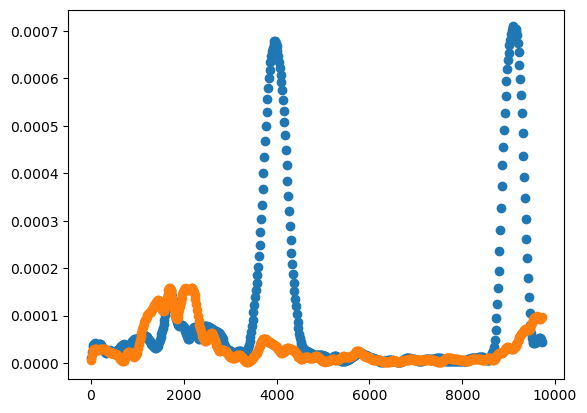

In [30]:
file = '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch3_g10_compr.eaf.csv'
sample = pd.read_csv(file)
entropy2 = entrophyts2D(sample, "WRIST", "RIGHT_", "arms")
entropy3 = entrophyts2D(sample, "WRIST", "LEFT_", "arms")

print(entropy2)
print(entropy3)

tempv2 = temporal_variability_function2D(sample, "WRIST", "RIGHT_", "arms")
tempv3 = temporal_variability_function2D(sample, "WRIST", "LEFT_", "arms")

print(tempv2)
print(tempv3)

#print(gesturespace(sample, "WRIST", "RIGHT_", "arms"))
#print(gesturespace(sample, "WRIST", "LEFT_", "arms"))

#plt.plot(sample['time'], sample['RIGHT_WRIST_speed2D_smoothed204'], marker='x', linestyle='')
#plt.plot(sample['time'], sample['RIGHT_WRIST_speed2D_smoothed301'], marker='x', linestyle='')
plt.plot(sample['time'], sample['RIGHT_WRIST_speed2D'], marker='o', linestyle='')
plt.plot(sample['time'], sample['LEFT_WRIST_speed2D'], marker='o', linestyle='')

#plt.plot(sample['time'], sample['Y_RIGHT_WRIST'], marker='o', linestyle='')
#plt.plot(sample['time'], sample['Y_LEFT_WRIST'], marker='o', linestyle='')

(array([0.93537969]), np.float64(1.7386162895751154))
(array([0.98254446]), np.float64(1.7983210030210401))


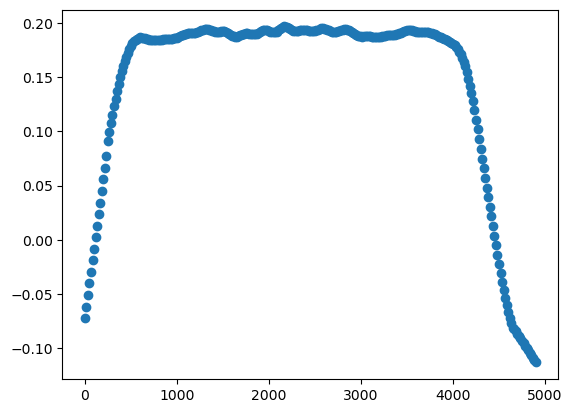

In [17]:
file = '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch3_g12_compr.eaf.csv'
sample = pd.read_csv(file)
entropy2 = entrophyts2D(sample, "WRIST", "RIGHT_", "arms")
entropy3 = entrophyts2D(sample, "WRIST", "LEFT_", "arms")

print(entropy2)
print(entropy3)

#print(gesturespace(sample, "WRIST", "RIGHT_", "arms"))
#print(gesturespace(sample, "WRIST", "LEFT_", "arms"))

#plt.plot(sample['time'], sample['RIGHT_WRIST_speed2D_smoothed204'], marker='x', linestyle='')
#plt.plot(sample['time'], sample['RIGHT_WRIST_speed2D_smoothed301'], marker='x', linestyle='')
plt.plot(sample['time'], sample['Y_RIGHT_WRIST'], marker='o', linestyle='')
#plt.plot(sample['time'], sample['Y_LEFT_WRIST'], marker='o', linestyle='')

# Graphing for a single file for variability

variability: 
0.0


'\n# graph file two\nfile2 = "/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch3_g12_compr.eaf.csv"\nsample2 = pd.read_csv(file2)\nmovement_sample2 = sample2[sample2[\'arms\'] == "movement"]\nspeed_ts2 = (movement_sample2["LEFT_" + \'WRIST\' + "_speed2D"]).to_numpy()\navg_height2 = np.mean(speed_ts2)\npeaks2, _ = scipy.signal.find_peaks(speed_ts2, avg_height2)\n\nplt.plot(speed_ts2, label="Speed Time Series")\nplt.plot(peaks2, speed_ts2[peaks2], "x", label="Peaks")\n\n# to calculate the total variability \ndiff_in_peaks = np.empty(len(peaks2)-1)\nprint(diff_in_peaks)\nfor i in range(len(peaks2)-1): \n    current_peak = sample2.loc[peaks2[i], "time" ]\n    next_peak = sample2.loc[peaks2[i+1], "time" ]\n    time_between_peaks = next_peak - current_peak\n    diff_in_peaks[i] = time_between_peaks\n\nvariability= np.std(diff_in_peaks)\nprint("variability 2: ")\nprint(variability)\n'

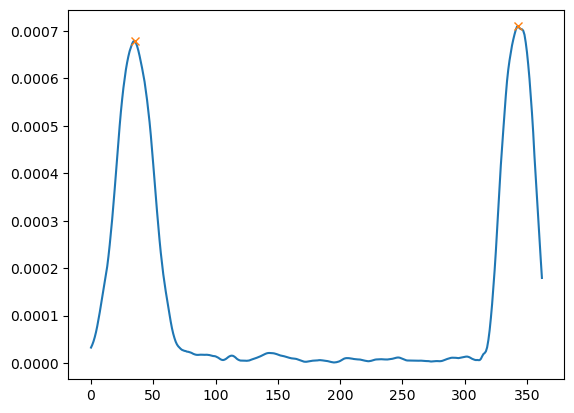

In [32]:
# graph file one
file = "/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch3_g10_compr.eaf.csv"
sample = pd.read_csv(file)
movement_sample = sample[sample['arms'] == "movement"]
speed_ts = (movement_sample["RIGHT_" + 'WRIST' + "_speed2D"]).to_numpy()
avg_height = np.mean(speed_ts)
peaks, _ = scipy.signal.find_peaks(speed_ts, avg_height)


plt.plot(speed_ts, label="Speed Time Series")
plt.plot(peaks, speed_ts[peaks], "x", label="Peaks")

diff_in_peaks = np.empty(len(peaks)-1)
for i in range(len(peaks)-1): 
    current_peak = sample.loc[peaks[i], "time" ]
    next_peak = sample.loc[peaks[i+1], "time" ]
    time_between_peaks = next_peak - current_peak
    diff_in_peaks[i] = time_between_peaks

variability= np.std(diff_in_peaks)
print("variability: ")
print(variability)
'''
# graph file two
file2 = "/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch3_g12_compr.eaf.csv"
sample2 = pd.read_csv(file2)
movement_sample2 = sample2[sample2['arms'] == "movement"]
speed_ts2 = (movement_sample2["LEFT_" + 'WRIST' + "_speed2D"]).to_numpy()
avg_height2 = np.mean(speed_ts2)
peaks2, _ = scipy.signal.find_peaks(speed_ts2, avg_height2)

plt.plot(speed_ts2, label="Speed Time Series")
plt.plot(peaks2, speed_ts2[peaks2], "x", label="Peaks")

# to calculate the total variability 
diff_in_peaks = np.empty(len(peaks2)-1)
print(diff_in_peaks)
for i in range(len(peaks2)-1): 
    current_peak = sample2.loc[peaks2[i], "time" ]
    next_peak = sample2.loc[peaks2[i+1], "time" ]
    time_between_peaks = next_peak - current_peak
    diff_in_peaks[i] = time_between_peaks

variability= np.std(diff_in_peaks)
print("variability 2: ")
print(variability)
'''

In [ ]:
file = "/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch1_g9_compr.eaf.csv"

featuredf2 = pd.

count = 1
# get the sample
print(file)
sample = pd.read_csv(file)

# get the fileID 
featuredf.loc[count, "fileID"] = (sample["fileID"])[0]

# get the chainID and the participantID
featuredf.loc[count, "chainID"] = sample["participantID"][0]
chainID = featuredf["chainID"][count]
split_string = chainID.split('ch')[1]
split_string = split_string.split('g')
chain_num = split_string[0]
gen_num = split_string[1]
participantID = int(chain_num) * int(gen_num)
featuredf.loc[count, "participantID"] = participantID

# get the demographic information from the survey and puts it in correct row in featuredf 
matching_rows = demographics_read[demographics_read["Q1"] == str(int(participantID))]
if len(matching_rows) >0:
    demographic_row = matching_rows.iloc[0]
    matching_row = demographics_read[demographics_read["Q1"] == str(int(participantID))]
    featuredf.loc[count, columns_to_add] = matching_row.iloc[0].values
else:
    print("no matching demographics row")


# gesture space processing
#Get the gesture space measures

#left arm
featuredf["left_index_movement"] = gesturespace(sample, "INDEX", "LEFT_", "arms")
featuredf["left_wrist_movement"] = gesturespace(sample, "WRIST", "LEFT_", "arms")
featuredf["left_elbow_movement"] = gesturespace(sample, "ELBOW", "LEFT_", "arms")
featuredf["total_left_arm_movement"] = featuredf["left_index_movement"] + featuredf["left_wrist_movement"] + featuredf["left_elbow_movement"]

# right arm
featuredf["right_index_movement"] = gesturespace(sample, "INDEX", "RIGHT_", "arms")
featuredf["right_wrist_movement"] = gesturespace(sample, "WRIST", "RIGHT_", "arms")
featuredf["right_elbow_movement"] = gesturespace(sample, "ELBOW", "RIGHT_", "arms")
featuredf["total_right_arm_movement"] = featuredf["right_index_movement"] + featuredf["right_wrist_movement"] + featuredf["right_elbow_movement"]

# left leg
featuredf["left_ankle_movement"] = gesturespace(sample, "ANKLE", "LEFT_", "lower_body")
featuredf["left_knee_movement"] = gesturespace(sample, "KNEE", "LEFT_", "lower_body")
featuredf["left_hip_movement"] = gesturespace(sample, "HIP", "LEFT_", "lower_body")
featuredf["total_left_leg_movement"] = featuredf["left_ankle_movement"] + featuredf["left_knee_movement"] + featuredf["left_hip_movement"]

# right leg
featuredf["right_ankle_movement"] = gesturespace(sample, "ANKLE", "RIGHT_", "lower_body")
featuredf["right_knee_movement"] = gesturespace(sample, "KNEE", "RIGHT_", "lower_body")
featuredf["right_hip_movement"] = gesturespace(sample, "HIP", "RIGHT_", "lower_body")
featuredf["total_right_leg_movement"] = featuredf["right_ankle_movement"] + featuredf["right_knee_movement"] + featuredf["right_hip_movement"]

# head (nose)
featuredf["nose_movement"] = gesturespace(sample, "NOSE", "", "head_mov")
featuredf["total_head_movement"] = featuredf["nose_movement"]

# total gesture space
featuredf["total_gesture_space"] = featuredf["total_left_arm_movement"] + featuredf["total_right_arm_movement"] + featuredf["total_left_leg_movement"] + featuredf["total_right_leg_movement"] + featuredf['total_head_movement']

# get the entrophy for wrist, knee, and ankle. 
featuredf["left_knee_entropy"] = entrophyts(sample, "KNEE", "LEFT_", 'lower_body')



'''

#left arm
featuredf["left_index_movement"] = gesturespace(sample, "INDEX", "LEFT", "arms")
featuredf["left_wrist_movement"] = gesturespace(sample, "WRIST", "LEFT", "arms")
featuredf["left_elbow_movement"] = gesturespace(sample, "ELBOW", "LEFT", "arms")
featuredf["total_left_arm_movement"] = featuredf["left_index_movement"] + featuredf["left_wrist_movement"] + featuredf["left_elbow_movement"]

# right arm
featuredf["right_index_movement"] = gesturespace(sample, "INDEX", "RIGHT", "arms")
featuredf["right_wrist_movement"] = gesturespace(sample, "WRIST", "RIGHT", "arms")
featuredf["right_elbow_movement"] = gesturespace(sample, "ELBOW", "RIGHT", "arms")
featuredf["total_right_arm_movement"] = featuredf["right_index_movement"] + featuredf["right_wrist_movement"] + featuredf["right_elbow_movement"]

# left leg
featuredf["left_ankle_movement"] = gesturespace(sample, "ANKLE", "LEFT", "lower_body")
featuredf["left_knee_movement"] = gesturespace(sample, "KNEE", "LEFT", "lower_body")
featuredf["left_hip_movement"] = gesturespace(sample, "HIP", "LEFT", "lower_body")
featuredf["total_left_leg_movement"] = featuredf["left_ankle_movement"] + featuredf["left_knee_movement"] + featuredf["left_hip_movement"]
'''




/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch1_g9_compr.eaf.csv


/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: invalid value encountered in divide
  sampen = -np.log(N_temp[1:] / N_temp[:-1])


'\n\n#left arm\nfeaturedf["left_index_movement"] = gesturespace(sample, "INDEX", "LEFT", "arms")\nfeaturedf["left_wrist_movement"] = gesturespace(sample, "WRIST", "LEFT", "arms")\nfeaturedf["left_elbow_movement"] = gesturespace(sample, "ELBOW", "LEFT", "arms")\nfeaturedf["total_left_arm_movement"] = featuredf["left_index_movement"] + featuredf["left_wrist_movement"] + featuredf["left_elbow_movement"]\n\n# right arm\nfeaturedf["right_index_movement"] = gesturespace(sample, "INDEX", "RIGHT", "arms")\nfeaturedf["right_wrist_movement"] = gesturespace(sample, "WRIST", "RIGHT", "arms")\nfeaturedf["right_elbow_movement"] = gesturespace(sample, "ELBOW", "RIGHT", "arms")\nfeaturedf["total_right_arm_movement"] = featuredf["right_index_movement"] + featuredf["right_wrist_movement"] + featuredf["right_elbow_movement"]\n\n# left leg\nfeaturedf["left_ankle_movement"] = gesturespace(sample, "ANKLE", "LEFT", "lower_body")\nfeaturedf["left_knee_movement"] = gesturespace(sample, "KNEE", "LEFT", "lower_b